In [17]:
%load_ext autoreload
%autoreload 2
!pip install matplotlib torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [18]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
words = open('names.txt', 'r').read().splitlines()
words[:9]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper']

In [20]:
chars = list(set("".join(words)))
stoi = {v:k+1 for k,v in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}
print(stoi)
print(itos)
print(len(chars))

{'h': 1, 'x': 2, 'v': 3, 'q': 4, 'm': 5, 'b': 6, 'o': 7, 'j': 8, 'd': 9, 'z': 10, 'n': 11, 'k': 12, 'p': 13, 'r': 14, 'y': 15, 't': 16, 'u': 17, 'e': 18, 'l': 19, 'i': 20, 's': 21, 'a': 22, 'c': 23, 'g': 24, 'f': 25, 'w': 26, '.': 0}
{1: 'h', 2: 'x', 3: 'v', 4: 'q', 5: 'm', 6: 'b', 7: 'o', 8: 'j', 9: 'd', 10: 'z', 11: 'n', 12: 'k', 13: 'p', 14: 'r', 15: 'y', 16: 't', 17: 'u', 18: 'e', 19: 'l', 20: 'i', 21: 's', 22: 'a', 23: 'c', 24: 'g', 25: 'f', 26: 'w', 0: '.'}
26


In [21]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
vocab_size = len(itos)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [161]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) 
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# # BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
# parameters = [C, W1, W2, b2, b1]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [162]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1


    ## Batch Normization
    # preactivations need to be roughly gaussian with 0 mean and 1 stddev, because if they 
    # are too large, tanh will saturate and gradients will be tiny and if they are too small,
    # gradients in activate tanh(x) = x
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias



    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
      p.data += -lr * p.grad

    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2994
  10000/ 200000: 2.0511
  20000/ 200000: 2.3570
  30000/ 200000: 2.4071
  40000/ 200000: 1.9210
  50000/ 200000: 2.5524
  60000/ 200000: 2.4140
  70000/ 200000: 2.0429
  80000/ 200000: 2.3699
  90000/ 200000: 2.0290
 100000/ 200000: 1.8915
 110000/ 200000: 2.2421
 120000/ 200000: 2.0154
 130000/ 200000: 2.4365
 140000/ 200000: 2.2777
 150000/ 200000: 2.1534
 160000/ 200000: 1.8152
 170000/ 200000: 1.7326
 180000/ 200000: 1.9171
 190000/ 200000: 1.8194


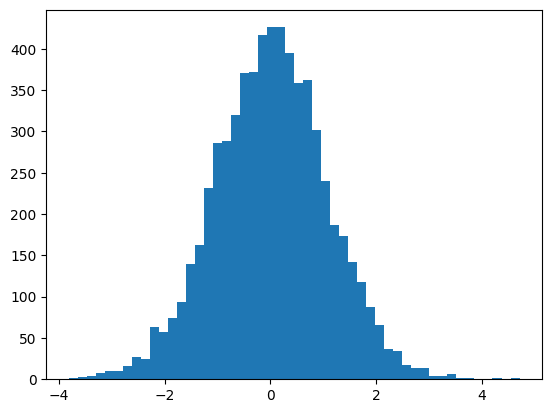

In [137]:
h.shape
plt.hist(hpreact.view(-1).tolist(), bins=50);

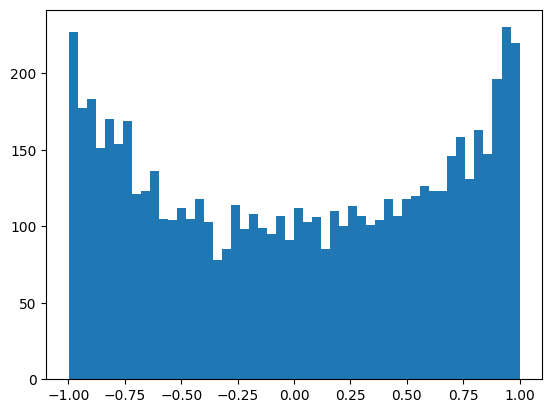

In [138]:
h.shape
plt.hist(h.view(-1).tolist(), bins=50);

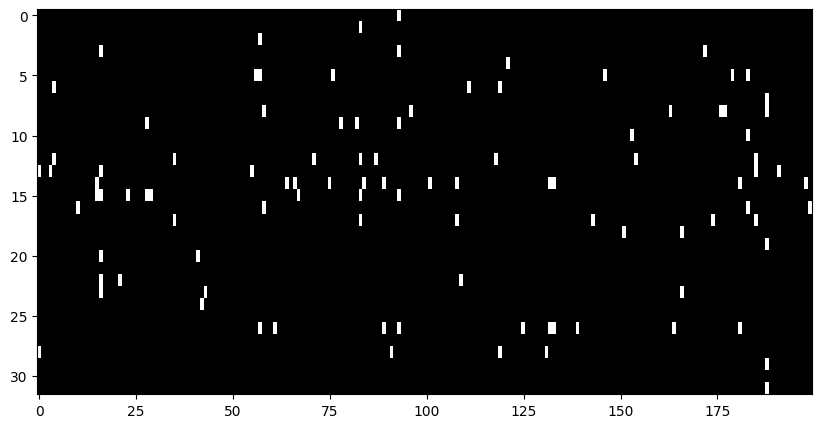

In [139]:
plt.figure(figsize=(10,5))
plt.imshow(h.abs()> .99, cmap='gray', interpolation='nearest', aspect='auto')

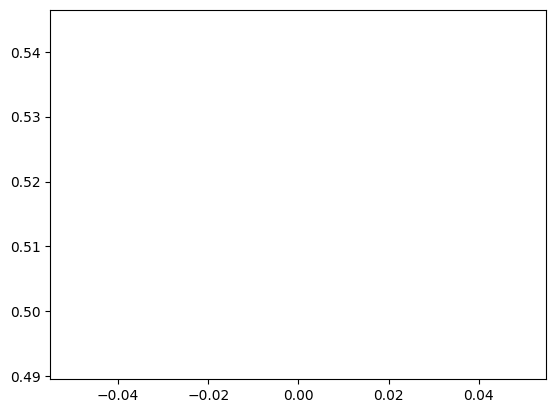

In [140]:
plt.plot(lossi)

In [154]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [142]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [163]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias

  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0412135124206543
val 2.1030683517456055


In [144]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

vaetwjguhxzjuanbncpetguijifnjnvhulnmzewjrxrbutclfjv.
aoujdsrmwpsutivpwddaqsgkjootjjxp.
tydrquxuziwlekdgch.
aaqxuscuwijyoqzhefgdgbnumstdslqxcmq.
mvydhioikbbjflbk.
sjtuopyaqzjnlfzetpuuylywlczvyzu.
cfvzdbemruntblhqkrsy.
wymxlenydhwjefrje.
ytnkjfregfj.
gudykyuxtkxaxxqr.
dtfupsdiztxabtwtqqotfvldlkucnnpverwhsurkzfqtn.
nacmlnhidnwhpqimak.
nf.
uqfviyyeycyynixfpysynbxbvc.
wydrjwvl.
rs.
myhdoruumeylvd.
dvbwfnxhqfdmksokvyrcwfwqzynjrkjbwulgpshqkizjaiyfhtkcsc.
gdlgceqba.
utjiwxdswwleaopnrxbfridflboqonrppz.


In [145]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [146]:
-torch.log(torch.tensor(1/27))

tensor(3.2958)

In [164]:
# C  = torch.randn((vocab_size, n_embd),            generator=g)
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) 
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
# W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
# b2 = torch.randn(vocab_size,                      generator=g) * 0

# # # BatchNorm parameters
# bngain = torch.ones((1, n_hidden))
# bnbias = torch.zeros((1, n_hidden))
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, W2, b2, bngain, bnbias]
# # parameters = [C, W1, W2, b2, b1]

# print(sum(p.nelement() for p in parameters)) # number of parameters in total
# for p in parameters:
#   p.requires_grad = True

In [ ]:
class Linear:
    def __init__(self, fan_in: int, fan_out: int, bias: bool):
        self.weights = torch.randn((fan_in, fan_out))
        self.bias = None
        if bias:
            self.bias = torch.randn(fan_out)



W1 = Linear((n_embd * block_size, n_hidden))